In [1]:
!pip install pyod

  ERROR: Could not find a version that satisfies the requirement pyod (from versions: none)
ERROR: No matching distribution found for pyod


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import gc; gc.enable()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline


/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/train.csv


In [3]:
PATH = '/kaggle/input/ashrae-energy-prediction/train.csv'
df = pd.read_csv(PATH)
df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


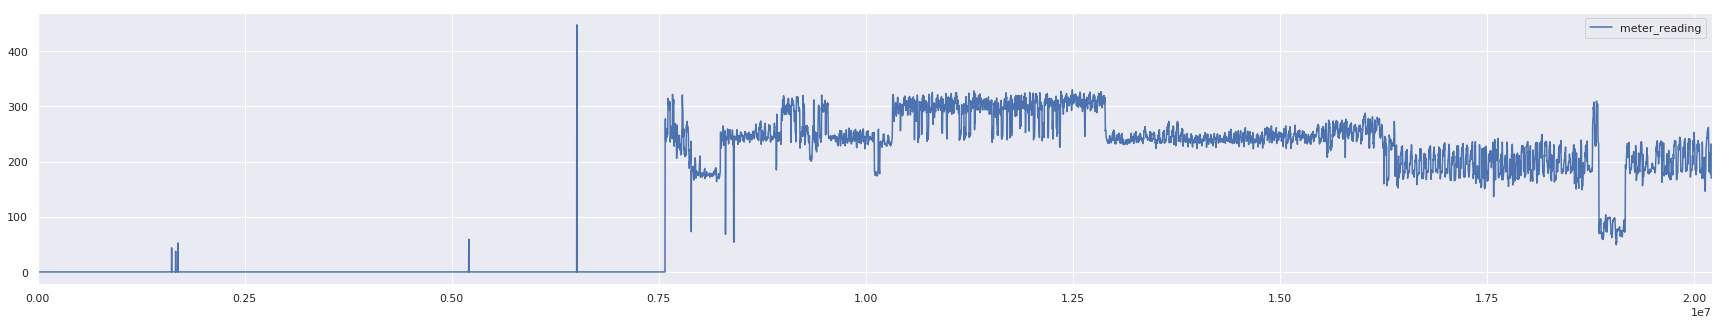

In [4]:
SIZE = (30,5)

df = df[df.building_id == 0]; gc.collect();

target = 'meter_reading'
df[[target]].plot(figsize=SIZE)
plt.show()

In [5]:
PATH = '/kaggle/input/ashrae-energy-prediction/building_metadata.csv'
meta = pd.read_csv(PATH)
meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [6]:
del meta; gc.collect();

In [7]:
PATH = '/kaggle/input/ashrae-energy-prediction/weather_train.csv'
weather = pd.read_csv(PATH)
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [8]:
weather = weather[weather.site_id == 0]
df = df.merge(weather[['timestamp', 'air_temperature']], on='timestamp', how='left')
del weather; gc.collect();
df.head()

,building_id,meter,timestamp,meter_reading,air_temperature
0,0,0,2016-01-01 00:00:00,0.0,25.0
1,0,0,2016-01-01 01:00:00,0.0,24.4
2,0,0,2016-01-01 02:00:00,0.0,22.8
3,0,0,2016-01-01 03:00:00,0.0,21.1
4,0,0,2016-01-01 04:00:00,0.0,20.0


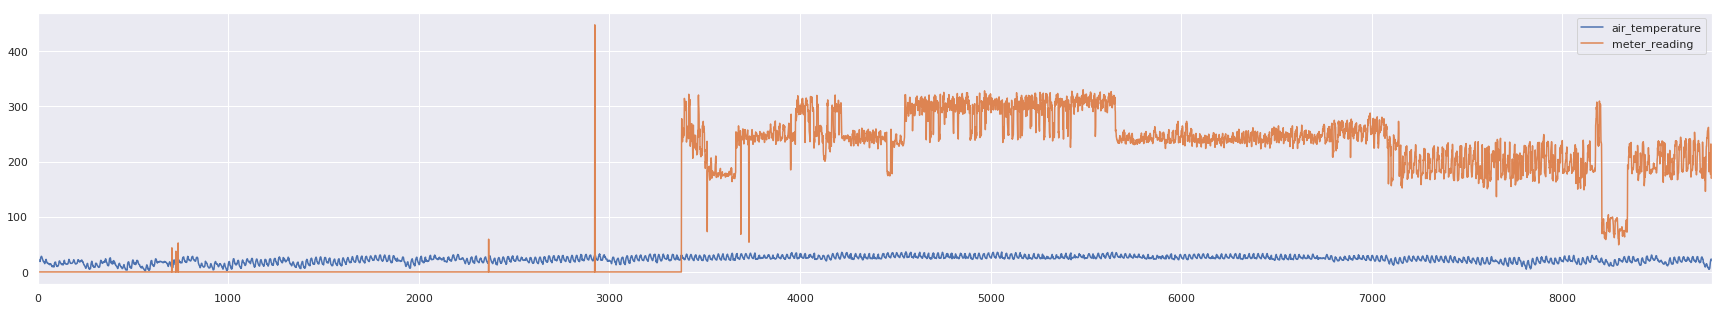

In [9]:
temp = 'air_temperature'
df[[temp, target]].plot(figsize=SIZE)
plt.show()

In [10]:
df[df[target] == 0].tail()

,building_id,meter,timestamp,meter_reading,air_temperature
3373,0,0,2016-05-20 13:00:00,0.0,24.4
3374,0,0,2016-05-20 14:00:00,0.0,26.7
3375,0,0,2016-05-20 15:00:00,0.0,28.3
3376,0,0,2016-05-20 16:00:00,0.0,30.0
3377,0,0,2016-05-20 17:00:00,0.0,30.6


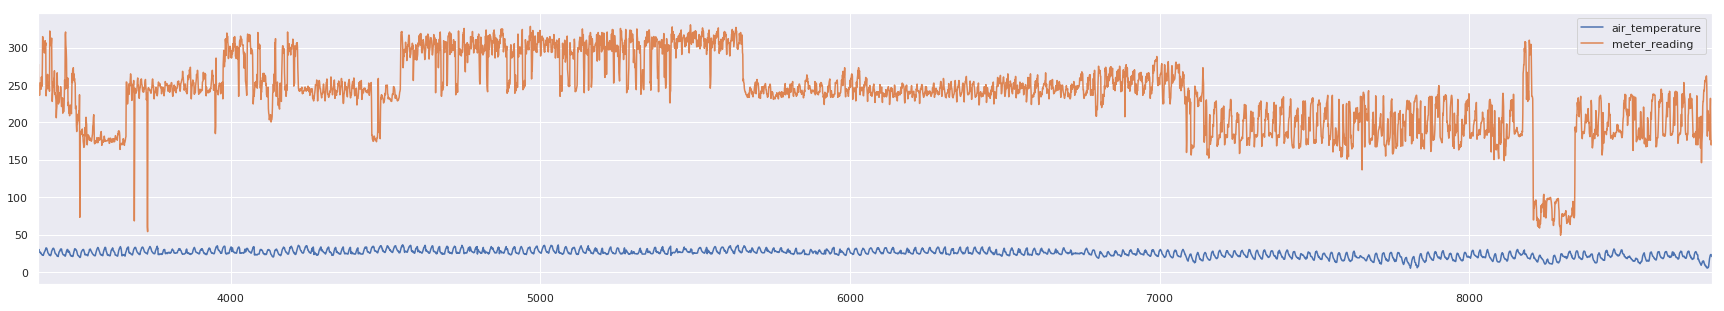

In [11]:
N = len(df[target])
n = 3377
df = df.tail(N-n); gc.collect();

df[[temp, target]].plot(figsize=SIZE)
plt.show()

In [12]:
scaler = RobustScaler()
model = LinearRegression()
pipe = make_pipeline(scaler, model)

X, y = df[[temp]].interpolate(), df[target]
score = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_log_error')
print(-score.mean(), "+/-", score.std())

0.06245179965052346 +/- 0.05475436311376952


In [13]:
y_pred = cross_val_predict(pipe, X, y, cv=5)
del X; del y; gc.collect();

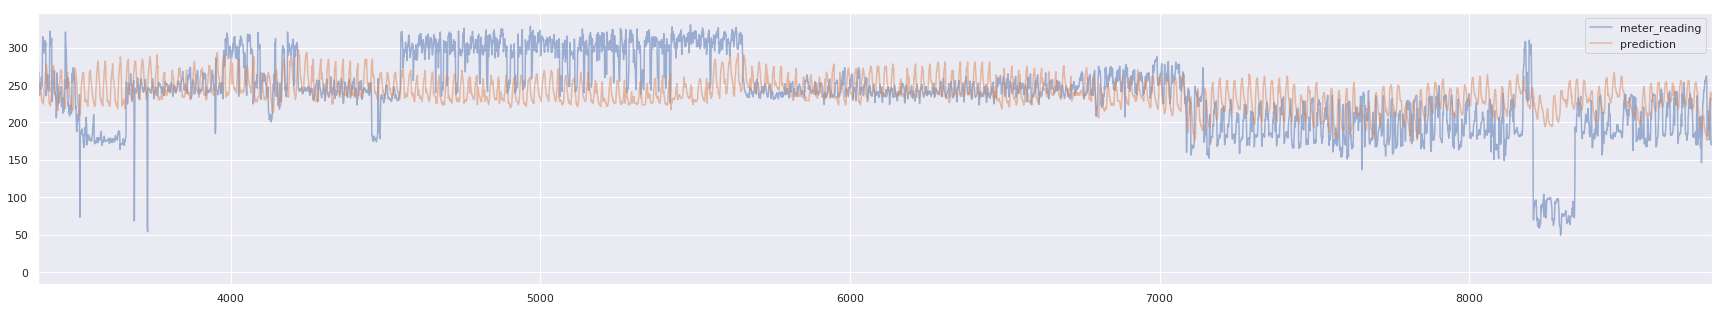

In [14]:
pred = 'prediction'
df[pred] = y_pred

df[[target, pred]].plot(figsize=SIZE, alpha=0.5)
plt.show()

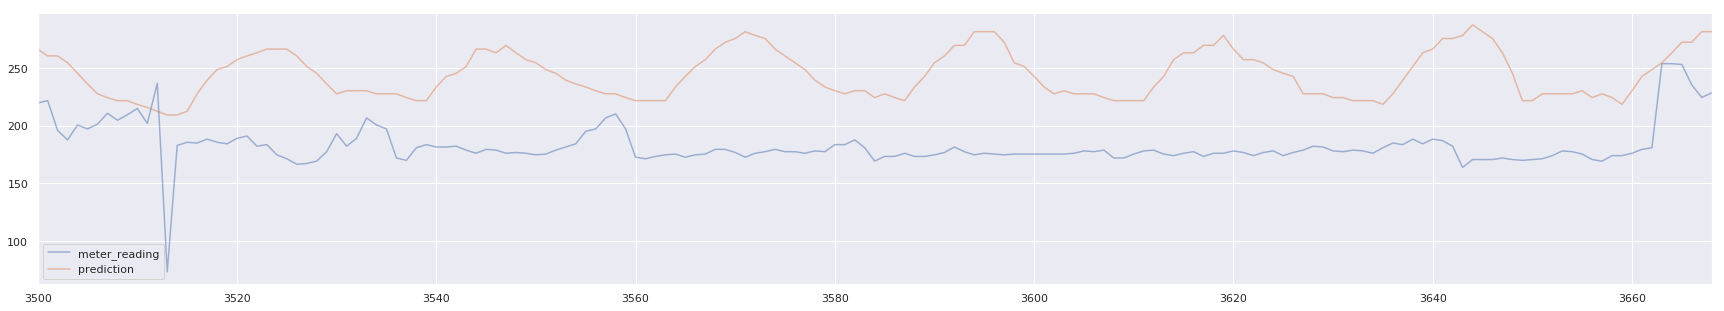

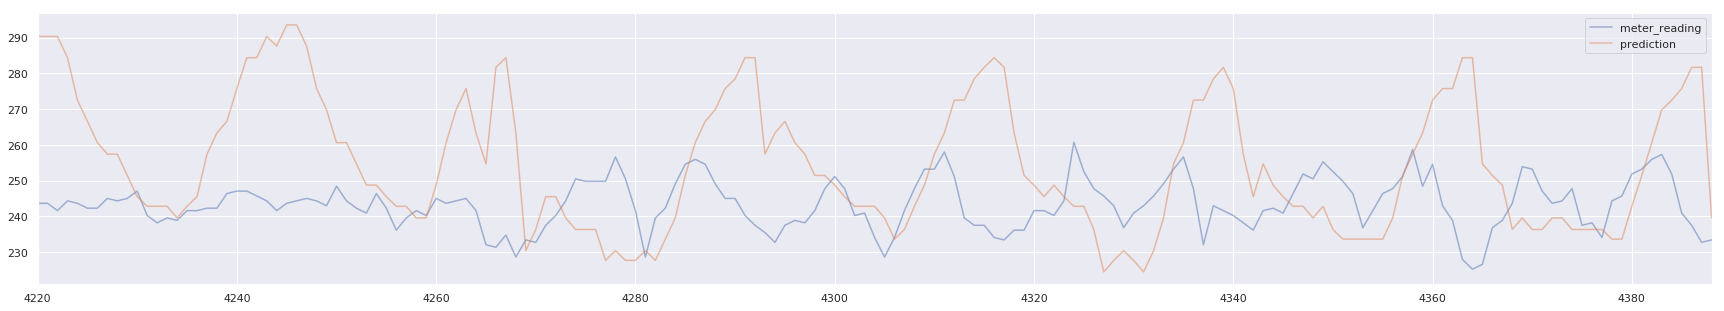

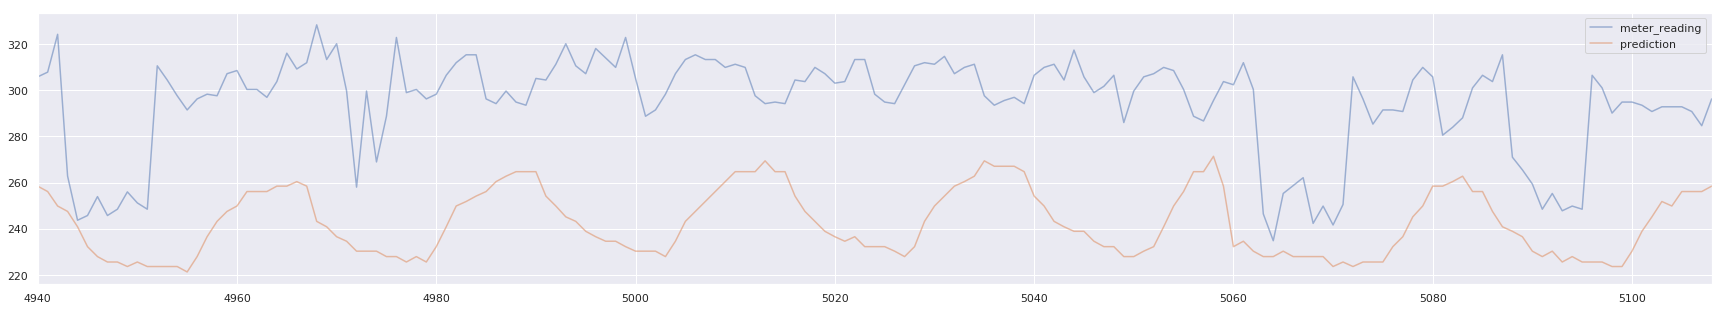

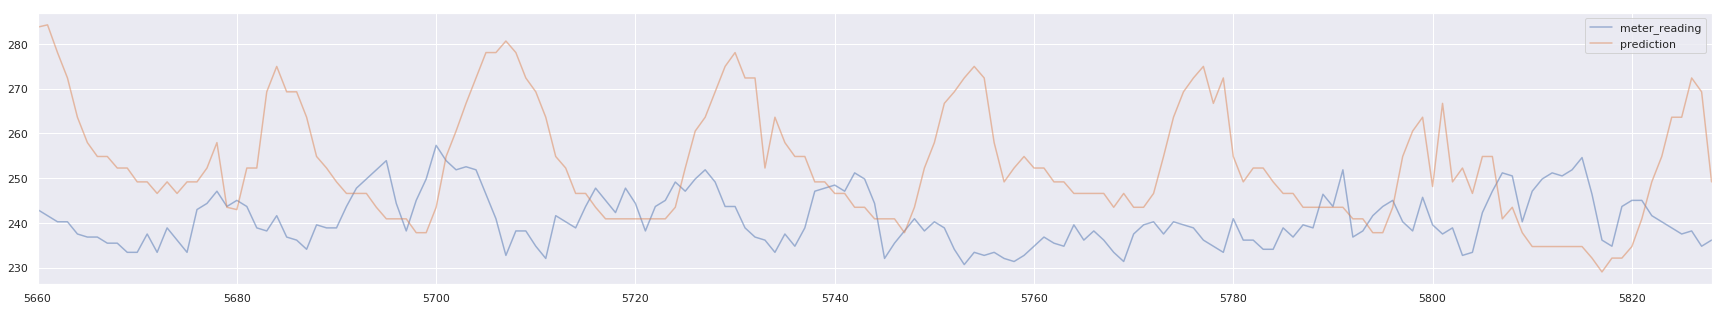

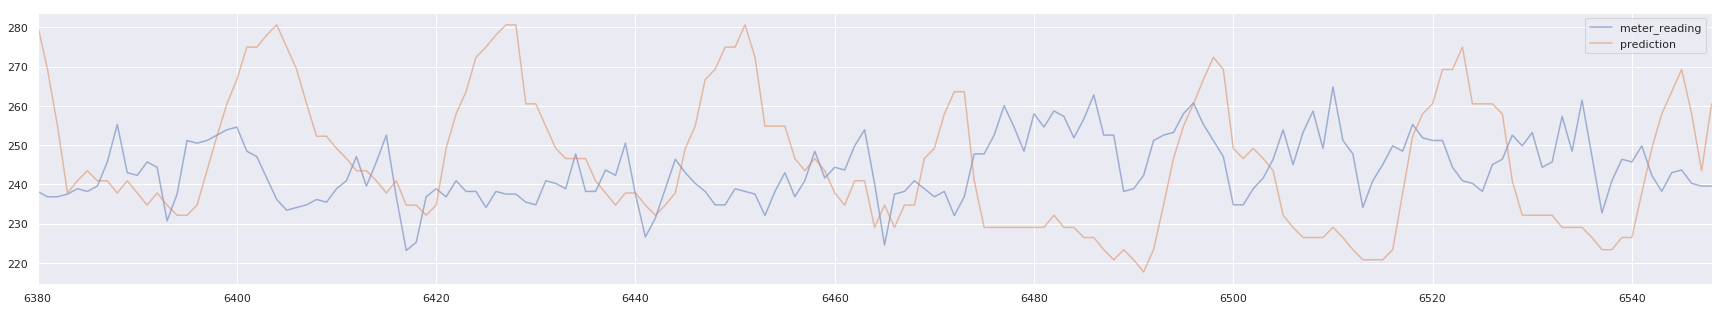

In [15]:
DAY = 24
WEEK = 7*DAY
MONTH = 30*DAY

for i in range(5):
    start = i*MONTH +3500
    df.loc[start:start+WEEK][[target, pred]].plot(figsize=SIZE, alpha=0.5)
    plt.show()

In [16]:
print('MAE:', mean_absolute_error(df[target], df[pred]))
print('MSLE:', mean_squared_log_error(df[target], df[pred]))
print('RMSLE:', np.sqrt(mean_squared_log_error(df[target], df[pred])))
print('R2:', r2_score(df[target], df[pred]))

MAE: 35.77922811878495
MSLE: 0.06244937006521086
RMSLE: 0.24989871961498894
R2: 0.07672380721101024


In [17]:
PATH = '/kaggle/input/ashrae-energy-prediction/weather_test.csv'
test = pd.read_csv(PATH)
test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [18]:
test = test[test.site_id == 0]; gc.collect();
test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [19]:
df = df.append(test[['timestamp', temp]], sort=True)
del test; gc.collect()

0

In [20]:
df

,air_temperature,building_id,meter,meter_reading,prediction,timestamp
3377,30.6,0.0,0.0,0.000,269.818643,2016-05-20 17:00:00
3378,25.0,0.0,0.0,232.753,239.594917,2016-05-20 18:00:00
3379,25.6,0.0,0.0,277.802,242.833173,2016-05-20 19:00:00
3380,28.3,0.0,0.0,238.896,257.405327,2016-05-20 20:00:00
3381,30.0,0.0,0.0,240.944,266.580387,2016-05-20 21:00:00
...,...,...,...,...,...,...
17515,27.8,NaN,NaN,NaN,NaN,2018-12-31 19:00:00
17516,27.2,NaN,NaN,NaN,NaN,2018-12-31 20:00:00
17517,27.8,NaN,NaN,NaN,NaN,2018-12-31 21:00:00
17518,26.7,NaN,NaN,NaN,NaN,2018-12-31 22:00:00


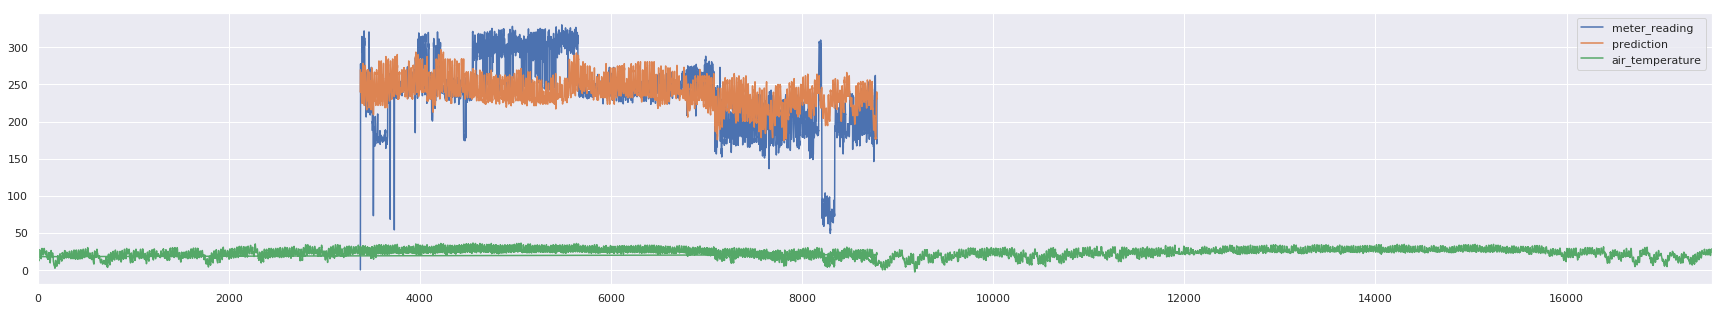

In [21]:
df[[target, pred, temp]].plot(figsize=SIZE)
plt.show()

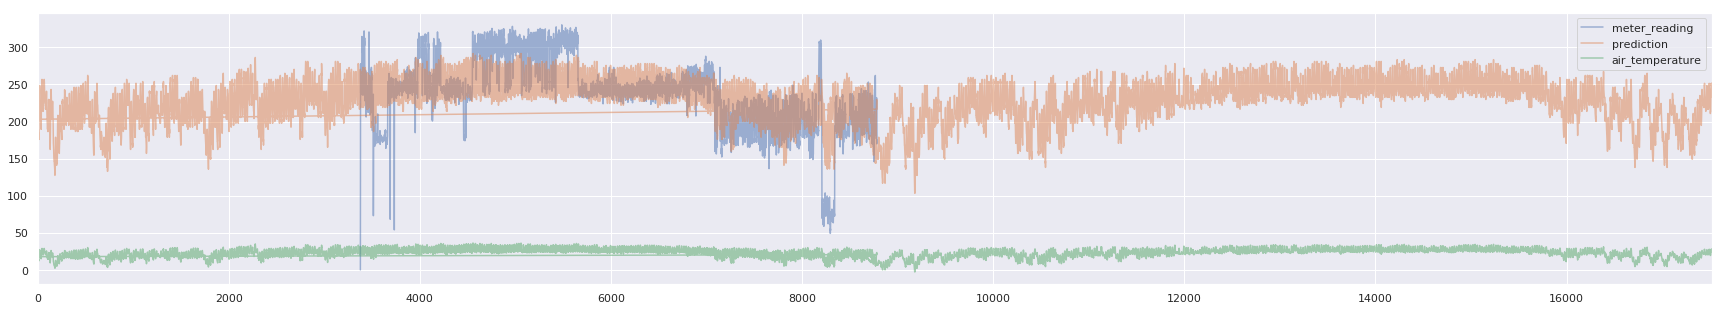

In [22]:
X_train, y_train = df.dropna()[[temp]], df.dropna()[target]
pipe.fit(X_train, y_train)
X = df[[temp]].interpolate()
y_pred = pipe.predict(X)
df[pred] = y_pred

df[[target, pred, temp]].plot(figsize=SIZE, alpha=0.5)
plt.show()

In [23]:
# Preprocessing:
# ==============
# * Pick training data
#   * Drop things
#   * Smooth things (Caveat: Don't kill cyclical/seasonal/periodic patterns)

# Modeling:
# =========
# * Prediction = func(Monthly Component) + func(Weekly Component) + func(Daily Component) + func(Hourly Component) + Other Terms
#
# * Prediction = func(What happened last year) --where func := smooth  [BASELINE]

# Featurization Ideas + Quick Improvements:
# =========================================
# * Frequency-based Features
#   * Day-of-Week (DoW)
#   * Month
#   * Time-of-Day
#   * isWeekend (indicator?)
#   * Auto-correlations / Frequency Components (FFT)
# * Trend (Smoothed) Features
#   * Naive smoothing
# * Discretization
#   * Classification Problem POV
#   * Matrix/Distance Profile-based Features


In [24]:
def slope(y):
    y = y[np.isfinite(y)]
    x = range(len(y))
    m, b = np.polyfit(x, y, 1)
    return m

In [25]:
x = np.array(range(100))
y = 2*x+1 + np.random.normal(0,1)

slope(y)

2.0

In [26]:
df.head()

,air_temperature,building_id,meter,meter_reading,prediction,timestamp
3377,30.6,0.0,0.0,0.000,265.063539,2016-05-20 17:00:00
3378,25.0,0.0,0.0,232.753,237.936514,2016-05-20 18:00:00
3379,25.6,0.0,0.0,277.802,240.842981,2016-05-20 19:00:00
3380,28.3,0.0,0.0,238.896,253.922082,2016-05-20 20:00:00
3381,30.0,0.0,0.0,240.944,262.157072,2016-05-20 21:00:00


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


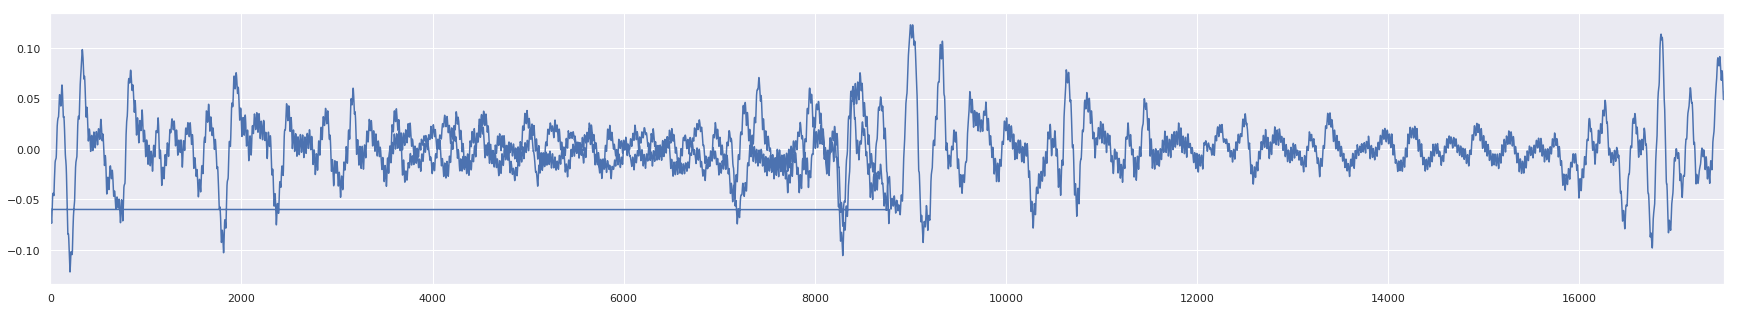

In [27]:
df[temp].rolling(WEEK).apply(lambda x: slope(x)).plot(figsize=SIZE)
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


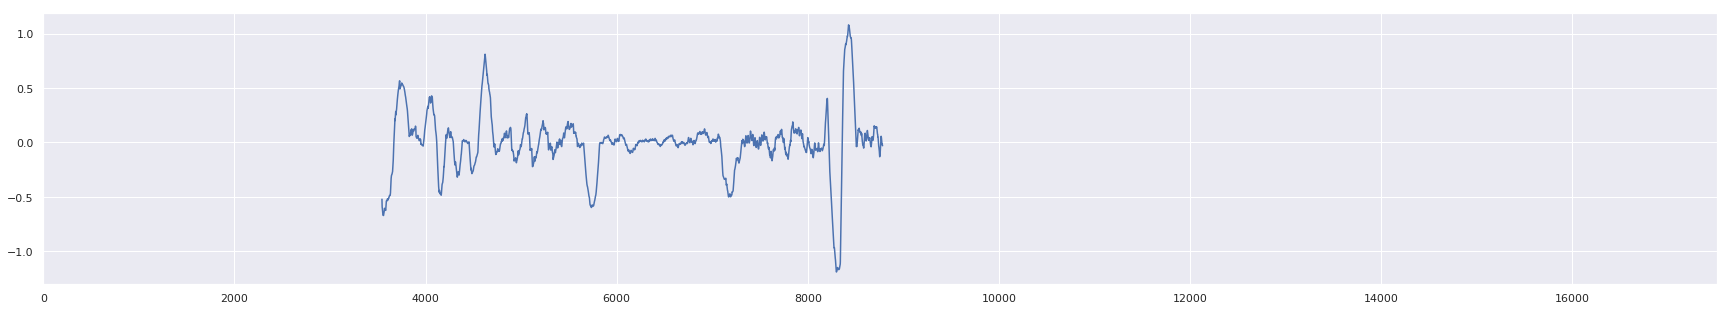

In [28]:
df[target].rolling(WEEK).apply(lambda x: slope(x)).plot(figsize=SIZE)
plt.show()